In [132]:
import pandas as pd
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import numpy as np
import seaborn as sns
import scipy.stats as stats
import plotly.express as px
from sklearn.decomposition import PCA
from statannotations.Annotator import Annotator

In [2]:
#### Helper function defined here ####
# convert the p-values into asterics values
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

## 1. Replicate the First Plot (includes p-values) ##

qPCR validation of the expression of select IFN signaling pathway genes (Reactome pathway enrichment analysis [Fig. 3B]). The gene expression levels are shown as fold change of nicotine exposed cells over their respective controls. UT: untreated BEAS-2B cells; UT-NTE: UT cells exposed to 2.5 μM nicotine; NiW: nickel washed-out cells; NiW-NTE: NiW cells exposed to 2.5 μM nicotine. Error bars represent standard deviations of at least two biological replicates. Statistical significance was evaluated using the t-test.

### Read in the Data and Filter/Format ###

In [136]:
# import the count data as a pandas dataframe
df = pd.read_csv('GSE242791_Nickel_Nicotine.csv', sep=',', index_col = 0)
# transpose the data to get in the right format for DEA
counts_df = df.T
# filter out genes with less than 10 read counts in total
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

In [98]:
counts_df

,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000238009,ENSG00000233750,ENSG00000268903,ENSG00000269981,ENSG00000239906,...,ENSG00000278384,ENSG00000278066,ENSG00000276345,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000271254,ENSG00000275405,ENSG00000277475,ENSG00000268674
B2Bcontrolrep1,23,1079,10,0,2,30,28,34,9,1,...,20,122,788,5,20,6,3475,2,20,0
B2Bcontrolrep2,26,1675,12,1,2,43,32,54,18,5,...,38,186,1461,11,32,5,6021,3,26,2
B2BNicotine125rep1,21,1382,10,2,3,50,38,36,9,4,...,19,150,1124,24,35,6,4653,7,19,0
B2BNicotine125rep2,16,1394,3,1,0,45,23,41,16,8,...,27,167,1233,26,34,9,4449,7,20,4
B2BNicotine250rep1,11,1278,8,4,1,32,21,35,15,1,...,20,134,1184,22,33,13,4341,0,30,0
B2BNicotine250rep2,32,2531,15,6,1,57,52,74,26,5,...,40,249,1950,38,65,11,7594,2,32,2
Hcontrolrep1,14,954,9,4,0,19,24,20,21,4,...,27,112,1081,17,15,10,3531,2,9,1
Hcontrolrep2,18,1382,4,2,0,31,37,54,15,4,...,38,159,1349,26,20,7,4406,3,21,3
Hcontrol125rep1,16,2071,16,15,0,51,55,82,32,10,...,45,192,1839,23,24,14,6444,4,41,3
Hcontrol125rep2,17,1249,6,2,0,26,34,42,16,3,...,36,131,1458,32,17,10,4449,5,8,1


In [6]:
# get the sample names
rownames = list(counts_df.index)
# put the condition names in a list for each sample
groupnames = ['UT','UT','UT-NTE 1.25','UT-NTE 1.25','UT-NTE 2.5','UT-NTE 2.5',
              'NiW','NiW','NiW-NTE 1.25','NiW-NTE 1.25','NiW-NTE 2.5','NiW-NTE 2.5']
# create a dataframe of the metadata
metadata = pd.DataFrame(
    {'sample': rownames,
     'condition': groupnames
    })
metadata.index = counts_df.index
metadata = metadata.drop(['sample'], axis=1)

In [7]:
metadata

,condition
B2Bcontrolrep1,UT
B2Bcontrolrep2,UT
B2BNicotine125rep1,UT-NTE 1.25
B2BNicotine125rep2,UT-NTE 1.25
B2BNicotine250rep1,UT-NTE 2.5
B2BNicotine250rep2,UT-NTE 2.5
Hcontrolrep1,NiW
Hcontrolrep2,NiW
Hcontrol125rep1,NiW-NTE 1.25
Hcontrol125rep2,NiW-NTE 1.25


### Performing DESEQ2 ###

In [8]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    n_cpus=8,
)

In [9]:
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 7.70 seconds.

Fitting dispersion trend curve...
... done in 7.59 seconds.

Fitting MAP dispersions...
... done in 7.03 seconds.

Fitting LFCs...
... done in 6.30 seconds.

Refitting 0 outliers.



In [11]:
stat_res1 = DeseqStats(dds, n_cpus=8, contrast = ("condition", "UT-NTE 2.5", "UT"))
stat_res2 = DeseqStats(dds, n_cpus=8, contrast = ("condition", "NiW-NTE 2.5", "NiW"))

In [12]:
stat_res1.summary()
stat_res2.summary()

Running Wald tests...
... done in 2.12 seconds.



Log2 fold change & Wald test p-value: condition UT-NTE 2.5 vs UT


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000223972,19.941493,-0.648472,0.504103,-1.286386,0.198308,0.408360
ENSG00000227232,1564.069865,0.081286,0.093028,0.873776,0.382240,0.609198
ENSG00000278267,10.535160,-0.338967,0.727961,-0.465639,0.641474,0.806741
ENSG00000243485,3.997882,2.986249,1.781009,1.676718,0.093598,NaN
ENSG00000237613,1.034165,-1.358451,2.256058,-0.602135,0.547084,NaN
...,...,...,...,...,...,...
ENSG00000275661,9.879912,0.808911,0.778872,1.038567,0.299006,NaN
ENSG00000271254,5149.561946,-0.017977,0.055433,-0.324311,0.745703,0.870517
ENSG00000275405,3.781773,-1.768154,1.532518,-1.153758,0.248600,NaN
ENSG00000277475,23.433189,0.120805,0.530579,0.227686,0.819891,0.910825


Running Wald tests...
... done in 2.15 seconds.



Log2 fold change & Wald test p-value: condition NiW-NTE 2.5 vs NiW


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000223972,19.941493,-0.323186,0.518057,-0.623842,0.532732,0.710911
ENSG00000227232,1564.069865,0.175536,0.092782,1.891921,0.058502,0.152831
ENSG00000278267,10.535160,0.796112,0.736870,1.080397,0.279966,0.472540
ENSG00000243485,3.997882,0.740876,1.143501,0.647902,0.517048,NaN
ENSG00000237613,1.034165,2.173298,3.137359,0.692716,0.488488,NaN
...,...,...,...,...,...,...
ENSG00000275661,9.879912,-0.062045,0.723482,-0.085759,0.931658,NaN
ENSG00000271254,5149.561946,0.065041,0.055268,1.176826,0.239265,0.424852
ENSG00000275405,3.781773,0.309030,1.184194,0.260962,0.794122,NaN
ENSG00000277475,23.433189,0.327605,0.551053,0.594508,0.552173,0.726850


In [13]:
# get the dataframes of the deseq statistic results
ut_nte = stat_res1.results_df
niw_nte = stat_res2.results_df

In [14]:
# get the rows for the genes wanted in the deseq statistic results dataframes
hlaf_filtered_df1 = ut_nte.loc['ENSG00000204642',:]
hlaf_filtered_df2 = niw_nte.loc['ENSG00000204642',:]

ifim1_filtered_df1 = ut_nte.loc['ENSG00000185885',:]
ifim1_filtered_df2 = niw_nte.loc['ENSG00000185885',:]

irf6_filtered_df1 = ut_nte.loc['ENSG00000117595',:]
irf6_filtered_df2 = niw_nte.loc['ENSG00000117595',:]

mx1_filtered_df1 = ut_nte.loc['ENSG00000157601',:]
mx1_filtered_df2 = niw_nte.loc['ENSG00000157601',:]

### Plot the Bar Graphs ###

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UT vs. UT-NTE: p=ns
NiW vs. NiW-NTE: p=****
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UT vs. UT-NTE: p=ns
NiW vs. NiW-NTE: p=****
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UT vs. UT-NTE: p=****
NiW vs. NiW-NTE: p=****
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

UT vs. UT-NTE: p=**
NiW vs. NiW-NTE: p=****


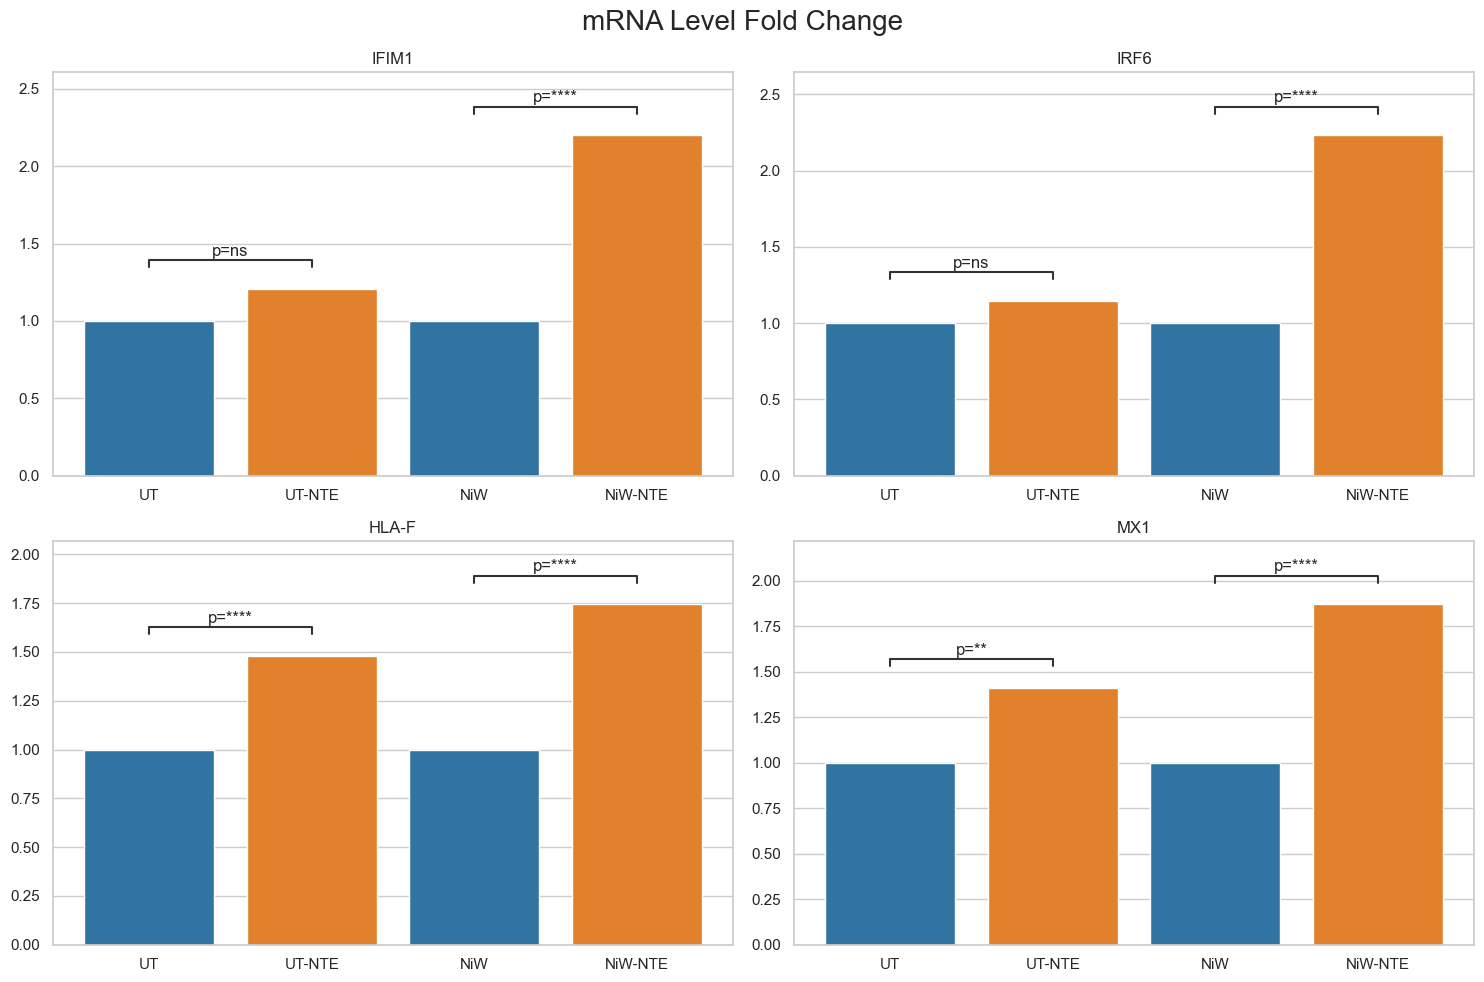

In [155]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.5, wspace=0.125)
fig.suptitle('mRNA Level Fold Change', fontsize=20)
# define the labels for the x-axis
x_labels = ['UT','UT-NTE', 'NiW', 'NiW-NTE']
# define the bar colors
bar_colors = ['tab:blue', 'tab:orange', 'tab:blue', 'tab:orange']
#define the pairs for the annotations
pairs = [('UT', 'UT-NTE'),
         ('NiW', 'NiW-NTE')] 

### IFIM1 PLOT ###

# construct the string containing the padj value
ifim1_pval1 = convert_pvalue_to_asterisks(ifim1_filtered_df1.padj)
ifim1_pval2 = convert_pvalue_to_asterisks(ifim1_filtered_df2.padj)
caption1 = ["p=" + str(ifim1_pval1), "p=" + str(ifim1_pval2)]

# plot the bar plot for fold change values
sns.barplot(y=[1, 2**ifim1_filtered_df1.log2FoldChange, 1, 2**ifim1_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[0,0]).set(title='IFIM1')

# create the p-values annotations
annotator1 = Annotator(axes[0,0], pairs, y=[1, 2**ifim1_filtered_df1.log2FoldChange, 1, 2**ifim1_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors)
annotator1.set_custom_annotations(caption1)
annotator1.annotate()

### IRF6 PLOT ###

# construct the string containing the padj value
irf6_pval1 = convert_pvalue_to_asterisks(irf6_filtered_df1.padj)
irf6_pval2 = convert_pvalue_to_asterisks(irf6_filtered_df2.padj)
caption2 = ["p=" + str(irf6_pval1), "p=" + str(irf6_pval2)]

# plot the bar plot for fold change values
sns.barplot(y=[1, 2**irf6_filtered_df1.log2FoldChange, 1, 2**irf6_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[0,1]).set(title='IRF6')

# create the p-values annotations
annotator2 = Annotator(axes[0,1], pairs,y=[1, 2**irf6_filtered_df1.log2FoldChange, 1, 2**irf6_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors)
annotator2.set_custom_annotations(caption2)
annotator2.annotate()

### HLAF PLOT ###

# construct the string containing the padj value
hlaf_pval1 = convert_pvalue_to_asterisks(hlaf_filtered_df1.padj)
hlaf_pval2 = convert_pvalue_to_asterisks(hlaf_filtered_df2.padj)
caption3 = ["p=" + str(hlaf_pval1), "p=" + str(hlaf_pval2)]

# plot the bar plot for fold change values
sns.barplot(y=[1, 2**hlaf_filtered_df1.log2FoldChange, 1, 2**hlaf_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[1,0]).set(title='HLA-F')

# create the p-values annotations
annotator3 = Annotator(axes[1,0], pairs,y=[1, 2**hlaf_filtered_df1.log2FoldChange, 1, 2**hlaf_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors)
annotator3.set_custom_annotations(caption3)
annotator3.annotate()

### MX1 PLOT ###

# construct the string containing the padj value
mx1_pval1 = convert_pvalue_to_asterisks(mx1_filtered_df1.padj)
mx1_pval2 = convert_pvalue_to_asterisks(mx1_filtered_df2.padj)
caption4 = ["p=" + str(mx1_pval1), "p=" + str(mx1_pval2)]

# plot the bar plot for fold change values
sns.barplot(y=[1, 2**mx1_filtered_df1.log2FoldChange, 1, 2**mx1_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors,ax=axes[1,1]).set(title='MX1')

# create the p-values annotations
annotator4 = Annotator(axes[1,1], pairs,y=[1, 2**mx1_filtered_df1.log2FoldChange, 1, 2**mx1_filtered_df2.log2FoldChange], 
            x=x_labels, palette=bar_colors)
annotator4.set_custom_annotations(caption4)
annotator4.annotate()

# fix the formatting
fig.tight_layout()

## 2. Create the PCA Plot ##

PCA plot of the gene expression profiles (RNA-Seq analysis). Each dot represents a replicate, which is labelled by the respective exposure conditions.

In [116]:
# add a column for the sample names into the dataframe
counts_df = counts_df.rename_axis("condition").reset_index()

In [117]:
counts_df

,condition,ENSG00000223972,ENSG00000227232,ENSG00000278267,ENSG00000243485,ENSG00000237613,ENSG00000238009,ENSG00000233750,ENSG00000268903,ENSG00000269981,...,ENSG00000278384,ENSG00000278066,ENSG00000276345,ENSG00000273532,ENSG00000276351,ENSG00000275661,ENSG00000271254,ENSG00000275405,ENSG00000277475,ENSG00000268674
0,B2Bcontrolrep1,23,1079,10,0,2,30,28,34,9,...,20,122,788,5,20,6,3475,2,20,0
1,B2Bcontrolrep2,26,1675,12,1,2,43,32,54,18,...,38,186,1461,11,32,5,6021,3,26,2
2,B2BNicotine125rep1,21,1382,10,2,3,50,38,36,9,...,19,150,1124,24,35,6,4653,7,19,0
3,B2BNicotine125rep2,16,1394,3,1,0,45,23,41,16,...,27,167,1233,26,34,9,4449,7,20,4
4,B2BNicotine250rep1,11,1278,8,4,1,32,21,35,15,...,20,134,1184,22,33,13,4341,0,30,0
5,B2BNicotine250rep2,32,2531,15,6,1,57,52,74,26,...,40,249,1950,38,65,11,7594,2,32,2
6,Hcontrolrep1,14,954,9,4,0,19,24,20,21,...,27,112,1081,17,15,10,3531,2,9,1
7,Hcontrolrep2,18,1382,4,2,0,31,37,54,15,...,38,159,1349,26,20,7,4406,3,21,3
8,Hcontrol125rep1,16,2071,16,15,0,51,55,82,32,...,45,192,1839,23,24,14,6444,4,41,3
9,Hcontrol125rep2,17,1249,6,2,0,26,34,42,16,...,36,131,1458,32,17,10,4449,5,8,1


In [118]:
# get the conditions columns from the df (sample names)
conditions = counts_df['condition']
# drop so the df is all numeric
counts_df = counts_df.drop('condition', axis=1)

In [119]:
# compare to pulled out samples and ref to create new, grouped conditions
conditions = ['UT','UT','UT-NTE 1.25','UT-NTE 1.25','UT-NTE 2.5','UT-NTE 2.5',
              'NiW','NiW','NiW-NTE 1.25','NiW-NTE 1.25','NiW-NTE 2.5','NiW-NTE 2.5']

In [120]:
# log transform the counts data
log2_data = np.log2(counts_df + 1)

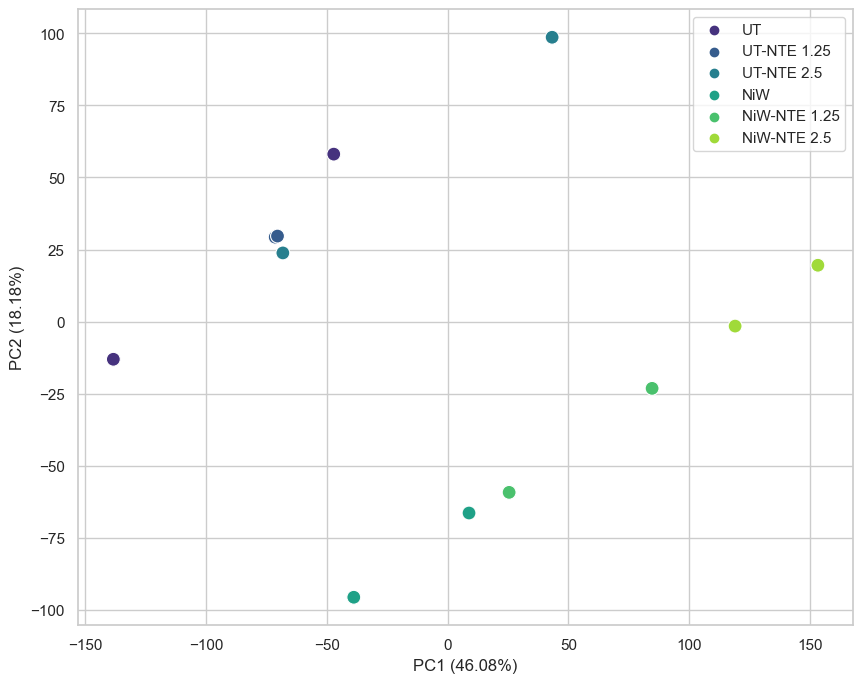

In [123]:
# perform PCA
pca = PCA(n_components=2)
pc_scores = pca.fit_transform(log2_data)

# create a DataFrame with PC scores
pc_df = pd.DataFrame(data={'PC1': pc_scores[:, 0], 'PC2': pc_scores[:, 1], 'Condition': conditions})

# percentage of variance explained by each PC
var_explained = pca.explained_variance_ratio_

# plot the pca plot - set fig size and style as well
sns.set(style='whitegrid')
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Condition', data=pc_df, palette='viridis', edgecolor='w', s=100)

# plot the percentage of variance explained
# adding x and y labels and a title
plt.xlabel(f'PC1 ({var_explained[0]*100:.2f}%)')
plt.ylabel(f'PC2 ({var_explained[1]*100:.2f}%)')

plt.legend()
plt.show()